In [1]:
try:
    evaluation = pd.read_csv('testeva.csv',index_col=0)
    evaluation = evaluation.T.sort_index()

    #droplist = ['cnn_train']
    #evaluation = evaluation.drop(droplist)

    fig,ax = plt.subplots(2)
    evaluation[['MSE','rmse']].plot.bar(ax=ax[0])
    ax[0].axhline(np.min(evaluation['MSE']),color='r',ls='--')
    ax[0].axhline(np.min(evaluation['rmse']),color='r',ls='--')

    evaluation[['NSE','R2']].plot.bar(ax=ax[1])
    ax[1].axhline(np.max(evaluation['NSE']),color='r',ls='--')
    ax[1].legend(loc='upper left')
    ax[0].legend(loc='upper left')
except: pass

In [2]:
from DLtools.Trial_evaluation_rec import record_list_result
from DLtools.Data import instant_data,station_sel
from DLtools.feature_sel import call_mar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import pywt
np.random.seed(42)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #ignore cuDNN log

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/song/anaconda3/envs/tf-gpu-c

In [3]:
from sklearn.metrics import r2_score
def forecast_accuracy(forecast, actual,title=None):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mse = np.mean((forecast - actual)**2)       #MSE

    nse = nashsutcliffe(actual,forecast)
    r2 = r2_score(actual, forecast)
    result = {'MSE':mse,'rmse':rmse,'R2':r2,'NSE':nse,'mape':mape,  'mae': mae,
            'mpe': mpe}
    result =  pd.Series(result,name=title)
    if title!=None:
        try: 
          eval = pd.read_csv('testeva.csv',index_col=0)
          pd.concat([eval,result],axis=1).to_csv('testeva.csv')
        except:
          eval = pd.DataFrame(result)
          eval.to_csv('testeva.csv')
    return result

def nashsutcliffe(Y_evaluation, Yhat_simulation):
    """
    Nash-Sutcliffe model efficinecy
        .. math::
         NSE = 1-\\frac{\\sum_{i=1}^{N}(e_{i}-s_{i})^2}{\\sum_{i=1}^{N}(e_{i}-\\bar{e})^2} 
    :evaluation: Observed data to compared with simulation data.
    :type: list
    :simulation: simulation data to compared with evaluation data
    :type: list
    :return: Nash-Sutcliff model efficiency
    :rtype: float
    """
    if len(Y_evaluation) == len(Yhat_simulation):
        s, e = np.array(Yhat_simulation), np.array(Y_evaluation)
        # s,e=simulation(Yhat),evaluation(Y)
        mean_observed = np.nanmean(e)
        # compute numerator and denominator
        numerator = np.nansum((e - s) ** 2)
        denominator = np.nansum((e - mean_observed)**2)
        # compute coefficient
        return 1 - (numerator / denominator)

In [4]:
############# Keras ###################
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
##--------------------------- SETTING AREA ------------------------------##
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
# df,mode = loading.daily_instant(),'day'
if mode =='hour': n_past,n_future = 24*7,72
elif mode =='day': n_past,n_future = 60,30
st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)

In [6]:
#--------------------------- 2 Yr Edit -----------------------------------#
host_path = './CPY012/2Yr_flood/'
start_p = '2016-01-01'
split_date = '2017-05-10'
stop_p = '2018-01-01'


In [7]:
#-----------------------Baseline / Hybrid -----------------------------------#
save_path =host_path+'trial'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [8]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
def split_xy(data,n_past,n_future):
    x,y = split_series(data.values,n_past,n_future)
    x = x.reshape((x.shape[0], x.shape[1],n_features))
    y = y[:,:,0]
    return x,y

In [9]:
#------------------------- Main ---------------------------------#
df = df[start_p:stop_p]
data = df
data['Day'] = data.index.dayofyear #add day
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')#interpolate neighbor first, for rest NA fill with mean() #.apply(lambda x: x.fillna(x.mean()),axis=0)

cutoff=.3
data_mar = call_mar(data,target,mode,cutoff=cutoff)
data_mar = move_column_inplace(data_mar,target,0)
n_features = len(data_mar.columns)

#------------------------
syn = ''
Yscale = False
allscale=True

data_mar.columns

Index(['CPY012_wl', 'CPY006_wl', 'YOM012_wl', 'DNP028_press', 'BKK013_wl',
       'BKK021_wl', 'WAN003_wl', 'WAN005_wl', 'NAN009_wl', 'PIN004_wl'],
      dtype='object')

# Split triantest

In [10]:
def wavelet_t(series,std):
    name = series.name
    idx = series.index
    signal = series.values
    if std: signal = (signal - signal.mean())/(signal.std())

    coeff = pywt.swt(signal,'db4',level=3)
    coeff = np.array(coeff)

    cA3,cD3 = coeff[0][0],coeff[0][1]
    _,cD2 = coeff[1][0],coeff[1][1]
    _,cD1 = coeff[2][0],coeff[2][1]
    #----------------------------
    dict_data = {
            '{}_cA3'.format(name): cA3,
            '{}_cD3'.format(name): cD3,
            '{}_cD2'.format(name): cD2,
            '{}_cD1'.format(name): cD1}
    wt = pd.DataFrame(dict_data,dtype='float32',index=idx)
    return wt
def df_wavelet(df,std):
    wav_df = pd.DataFrame()
    for col in df:
        a = wavelet_t(df[col],std)
        wav_df = pd.concat([wav_df,a],axis=1)
    return wav_df
def syn_column_select(data,sel_word):
    data_col = [i.split("_") for i in data.columns]
    _col =list()
    for i in data_col:
        if i[2]==sel_word : 
            i='_'.join(i)
            _col.append(i)
    return data[_col]

def st_column_select(data,sel_word):
    data_col = [i.split("_") for i in data.columns]
    _col =list()
    for i in data_col:
        if i[0]==sel_word : 
            i='_'.join(i)
            _col.append(i)
    return data[_col]

In [20]:
wdata = df_wavelet(data_mar,False)
wdata_A3 = syn_column_select(wdata,'cA3')
wdata_D3 = syn_column_select(wdata,'cD3')
wdata_D2 = syn_column_select(wdata,'cD2')
wdata_D1 = syn_column_select(wdata,'cD1')

<AxesSubplot:xlabel='date'>

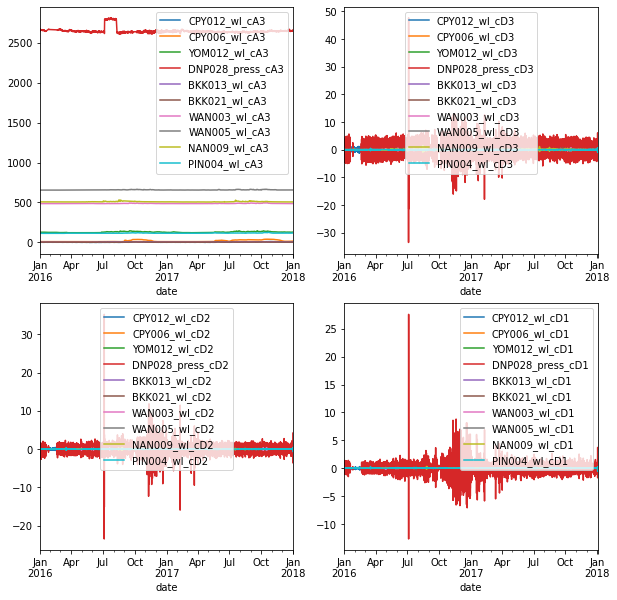

In [21]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
wdata_A3.plot(ax=ax[0][0])
wdata_D3.plot(ax=ax[0][1])
wdata_D2.plot(ax=ax[1][0])
wdata_D1.plot(ax=ax[1][1])

In [43]:
cpy = st_column_select(wdata,'CPY012')

##----------- SCALE
if allscale:
    syn = syn+'[X_sc]'  
    def scale_x(data):
        scaler = MinMaxScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])
        return data
    wdata_A3 = scale_x(wdata_A3)
    wdata_D3 = scale_x(wdata_D3)
    wdata_D2 = scale_x(wdata_D2)
    wdata_D1 = scale_x(wdata_D1)

# Y data
#if Yscale:
#    syn = syn+'[y_sc]'        
#    scaler_tar = MinMaxScaler()
#    scaler_tar.fit(data_mar[target].to_numpy().reshape(-1,1))
    
#scaler_tar = MinMaxScaler()
#scaler_tar.fit(data_mar[target].to_numpy().reshape(-1,1))
#data_mar[target] = scaler_tar.transform(data_mar[target].to_numpy().reshape(-1,1))

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

<AxesSubplot:xlabel='date'>

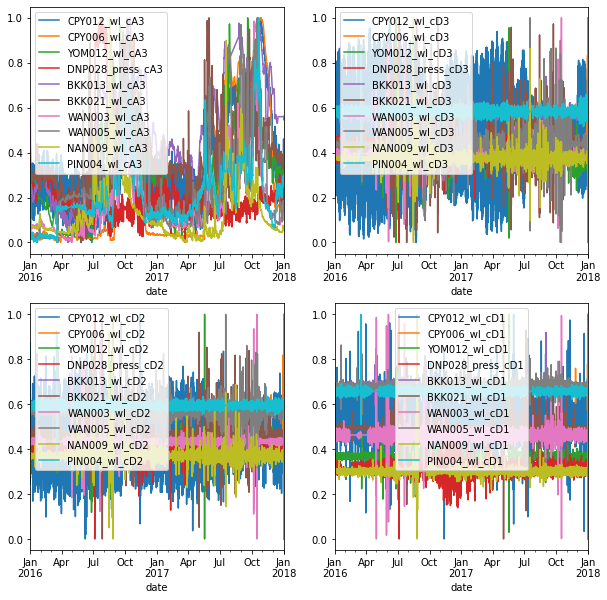

In [44]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
wdata_A3.plot(ax=ax[0][0])
wdata_D3.plot(ax=ax[0][1])
wdata_D2.plot(ax=ax[1][0])
wdata_D1.plot(ax=ax[1][1])

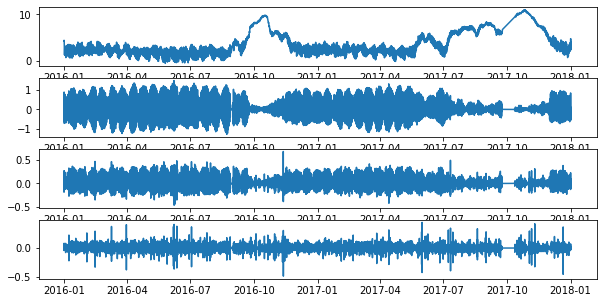

In [45]:
#std_sc = StandardScaler()
#cpy[cpy.columns] = std_sc.fit_transform(cpy[cpy.columns])

fig,ax = plt.subplots(4,1, figsize=(10,5))
for i in range(cpy.shape[1]):
    ax[i].plot(cpy.iloc[:,i])

<AxesSubplot:xlabel='date'>

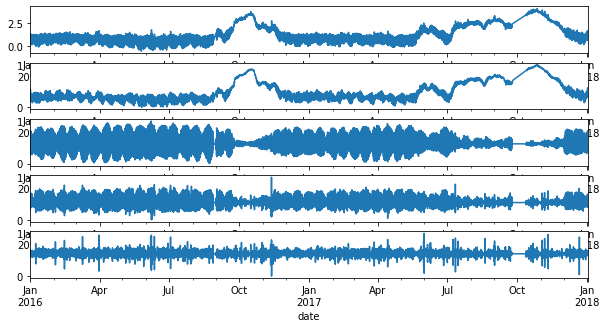

In [46]:
fig,ax = plt.subplots(5,1, figsize=(10,5))
data_mar.iloc[:,0].plot(ax=ax[0])
wdata_A3.iloc[:,0].plot(ax=ax[1])
wdata_D3.iloc[:,0].plot(ax=ax[2])
wdata_D2.iloc[:,0].plot(ax=ax[3])
wdata_D1.iloc[:,0].plot(ax=ax[4])

In [47]:
def autosplit(data):    
    ##----------- train test split 
    train,test = data[:split_date],data[split_date:]
    # ##--------- Wavelet_traintest
    X_train, y_train = split_xy(train,n_past,n_future)
    X_test, y_test= split_xy(test,n_past,n_future)
    return [X_train,X_test],[y_train,y_test]

In [49]:
Xa3,Ya3=autosplit(wdata_A3)
Xd3,Yd3=autosplit(wdata_D3)
Xd2,Yd2=autosplit(wdata_D2)
Xd1,Yd1=autosplit(wdata_D1)

In [50]:
train,test = cpy[:split_date],cpy[split_date:]

x,y = split_series(train.values,n_past,n_future)
x = x.reshape((x.shape[0], x.shape[1],4))
yA3_train = y[:,:,0]
yD3_train = y[:,:,1]
yD2_train = y[:,:,2]
yD1_train = y[:,:,3]
#--------------------------------------------
x,y = split_series(test.values,n_past,n_future)
x = x.reshape((x.shape[0], x.shape[1],4))
yA3_test = y[:,:,0]
yD3_test = y[:,:,1]
yD2_test = y[:,:,2]
yD1_test = y[:,:,3]
#--------------------------------------------
Ya3_ori = [yA3_train,yA3_test]
Yd3_ori = [yD3_train,yD3_test]
Yd2_ori = [yD2_train,yD2_test]
Yd1_ori = [yD1_train,yD1_test]

In [51]:
masterX,masterY =autosplit(data_mar)

# Deep learning

In [52]:
#------------ DL PARAMETER ---------------------#
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=2, verbose=2)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-5 * 0.90 ** x)
callbacks = [callback_early_stopping,reduce_lr]

In [53]:
def runmodel(model,X,Y):
    history = model.fit(X[0],Y[0],epochs=epochs,validation_data=(X[1],Y[1]),batch_size=batch,verbose=verbose,callbacks=callbacks)
    trainPred = model.predict(X[0])
    testPred = model.predict(X[1])

    if Yscale:
        Y[0] = scaler_tar.inverse_transform(Y[0])
        trainPred = scaler_tar.inverse_transform(trainPred.reshape(Y[0].shape))
        Y[1] = scaler_tar.inverse_transform(Y[1])
        testPred = scaler_tar.inverse_transform(testPred.reshape(Y[1].shape))
    return trainPred,testPred

In [54]:
#----------------------------------------------------------#
def build_lstm():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    # x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss=loss_f, optimizer=my_optimizer)
    model.summary()
    return model
#-------------------------------------------------------------#
def build_lstm_batch():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss=loss_f, optimizer=my_optimizer)
    model.summary()
    return model
#------------------------------------------------------------#
def build_cnn1d():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(144, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer=my_optimizer, loss=loss_f)    
    model.summary()
    return model
#-------------------------------------------------------------#
def build_ann():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Flatten()(input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(144, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer=my_optimizer, loss=loss_f)    
    model.summary()
    return model
#-------------------------------------------------------------#

In [141]:
def showresult(Yhat,Y):
    print(forecast_accuracy(Yhat[0],Y[0]))
    print(forecast_accuracy(Yhat[1],Y[1]))

    for i in range(72):
        plt.title(syn)
        plt.plot(Y[1][:,i],color='blue',alpha=0.1)
        plt.plot(Yhat[1][:,i],color='red',alpha=0.2)
    plt.legend()

#  [transform]> [wav] > [DL] > [wav] > [Inversetransform] 

ANN

In [52]:
ann = build_ann()
verbose, epochs,batch = 1, 30,8
my_optimizer = 'adam'
loss_f = 'mse'

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 168, 10)]         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1680)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1680)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               336200    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 144)               28944     
_________________________________________________________________
dense_13 (Dense)             (None, 72)                1044

In [59]:
#a3_predict = runmodel(ann,Xa3,[yA3_train,yA3_test])
#showresult(a3_predict,[yA3_train,yA3_test])

In [58]:
#d3_predict = runmodel(ann,Xd3,[yD3_train,yD3_test])
#showresult(d3_predict,[yD3_train,yD3_test])

In [57]:
#d2_predict = runmodel(ann,Xd2,[yD2_train,yD2_test])
#showresult(d2_predict,[yD2_train,yD2_test])

# CNN invertranform

In [68]:
verbose, epochs,batch = 1, 30,8
#my_optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
my_optimizer = 'adam'
loss_f = 'mse'
callbacks = [callback_early_stopping,reduce_lr]

model_c = build_cnn1d()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 168, 10)]         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 167, 64)           1344      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 83, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5312)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5312)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               1062600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0   

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 3s 256us/sample - loss: 4.4422 - val_loss: 2.3255
Epoch 2/30
11665/11665 [==============================] - 3s 242us/sample - loss: 1.1903 - val_loss: 1.1346
Epoch 3/30
11665/11665 [==============================] - 3s 269us/sample - loss: 0.9827 - val_loss: 0.9538
Epoch 4/30
11665/11665 [==============================] - 3s 248us/sample - loss: 0.9064 - val_loss: 0.9437
Epoch 5/30
11665/11665 [==============================] - 3s 241us/sample - loss: 0.8481 - val_loss: 0.9262
Epoch 6/30
11665/11665 [==============================] - 3s 235us/sample - loss: 0.8161 - val_loss: 0.9287
Epoch 7/30
11665/11665 [==============================] - 3s 292us/sample - loss: 0.7823 - val_loss: 0.8494
Epoch 8/30
11665/11665 [==============================] - 3s 252us/sample - loss: 0.7598 - val_loss: 0.8671
Epoch 9/30
11665/11665 [==============================] - 3s 236us/sample - loss: 0.743

MSE     0.570834
rmse    0.755535
R2      0.840203
NSE     0.840205
mape    0.904887
mae     0.620899
mpe     0.058943
dtype: float64
MSE     0.949424
rmse    0.974384
R2      0.830782
NSE     0.830852
mape    0.159894
mae     0.805426
mpe    -0.051025
dtype: float64


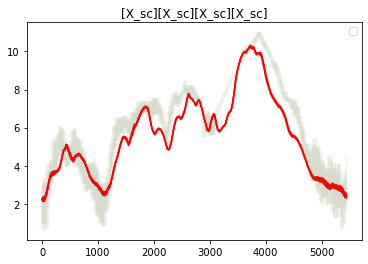

In [69]:
a3_predict_cnn = runmodel(model_c,Xa3,Ya3_ori)
showresult(a3_predict_cnn,Ya3_ori)

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 3s 241us/sample - loss: 0.5796 - val_loss: 0.0636
Epoch 2/30
11665/11665 [==============================] - 3s 255us/sample - loss: 0.2582 - val_loss: 0.0590
Epoch 3/30
11665/11665 [==============================] - 3s 255us/sample - loss: 0.2301 - val_loss: 0.0485
Epoch 4/30
11665/11665 [==============================] - 3s 229us/sample - loss: 0.1884 - val_loss: 0.0387
Epoch 5/30
11665/11665 [==============================] - 3s 232us/sample - loss: 0.1546 - val_loss: 0.0333
Epoch 6/30
11665/11665 [==============================] - 3s 232us/sample - loss: 0.1326 - val_loss: 0.0303
Epoch 7/30
11665/11665 [==============================] - 3s 229us/sample - loss: 0.1183 - val_loss: 0.0285
Epoch 8/30
11665/11665 [==============================] - 3s 228us/sample - loss: 0.1068 - val_loss: 0.0269
Epoch 9/30
11665/11665 [==============================] - 4s 317us/sample - loss: 0.097

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


MSE         0.049533
rmse        0.222561
R2          0.814222
NSE         0.814172
mape    37272.449219
mae         0.177380
mpe     -7141.801758
dtype: float64
MSE     0.023059
rmse    0.151851
R2      0.642709
NSE     0.642902
mape         inf
mae     0.113812
mpe          NaN
dtype: float64


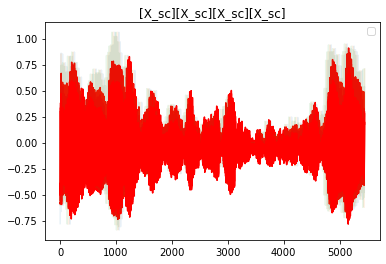

In [70]:
d3_predict_cnn = runmodel(model_c,Xd3,Yd3_ori)
showresult(d3_predict_cnn,Yd3_ori)

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 3s 248us/sample - loss: 0.0111 - val_loss: 0.0038
Epoch 2/30
11665/11665 [==============================] - 3s 247us/sample - loss: 0.0097 - val_loss: 0.0038
Epoch 3/30
11665/11665 [==============================] - 3s 229us/sample - loss: 0.0094 - val_loss: 0.0037
Epoch 4/30
11665/11665 [==============================] - 3s 234us/sample - loss: 0.0091 - val_loss: 0.0036
Epoch 5/30
11665/11665 [==============================] - 3s 225us/sample - loss: 0.0088 - val_loss: 0.0035
Epoch 6/30
11665/11665 [==============================] - 3s 230us/sample - loss: 0.0085 - val_loss: 0.0035
Epoch 7/30
11665/11665 [==============================] - 3s 258us/sample - loss: 0.0083 - val_loss: 0.0034
Epoch 8/30
11665/11665 [==============================] - 3s 228us/sample - loss: 0.0081 - val_loss: 0.0034
Epoch 9/30
11665/11665 [==============================] - 3s 225us/sample - loss: 0.007

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-c

MSE     0.006220
rmse    0.078868
R2      0.596490
NSE     0.596471
mape         inf
mae     0.060378
mpe          NaN
dtype: float64
MSE     0.003197
rmse    0.056542
R2      0.342156
NSE     0.342240
mape         inf
mae     0.039627
mpe          NaN
dtype: float64


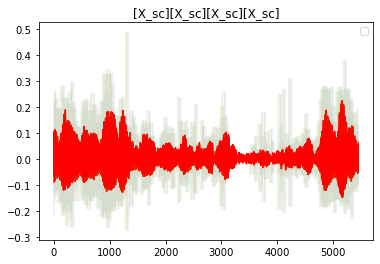

In [71]:
d2_predict_cnn = runmodel(model_c,Xd2,Yd2_ori)
showresult(d2_predict_cnn,Yd2_ori)

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 3s 248us/sample - loss: 0.0019 - val_loss: 0.0014
Epoch 2/30
11665/11665 [==============================] - 3s 229us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 3/30
11665/11665 [==============================] - 3s 227us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 4/30
11665/11665 [==============================] - 3s 232us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 5/30
11665/11665 [==============================] - 3s 243us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 6/30
11665/11665 [==============================] - 3s 229us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 7/30
11665/11665 [==============================] - 3s 232us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 8/30
11665/11665 [==============================] - 3s 260us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 9/30
11665/11665 [==============================] - 3s 253us/sample - loss: 0.001

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


MSE        0.001719
rmse       0.041462
R2         0.056262
NSE        0.056270
mape    2875.074951
mae        0.025578
mpe      117.989143
dtype: float64
MSE     0.001361
rmse    0.036891
R2      0.008673
NSE     0.008675
mape         inf
mae     0.017458
mpe          NaN
dtype: float64


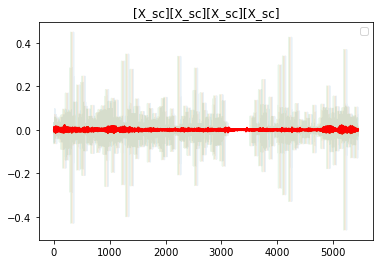

In [72]:
d1_predict_cnn = runmodel(model_c,Xd1,Yd1_ori)
showresult(d1_predict_cnn,Yd1_ori)

# cA with other model

In [73]:
def build_mod_cnn1d():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input)
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(x)
    x = layers.BatchNormalization()(x) # added
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(x)
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(2000, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1000, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(n_future, activation='linear')(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer='adam', loss='mse')    
    model.summary()
    return model

In [123]:
verbose, epochs,batch = 1, 30,16
my_optimizer = 'adam'
loss_f = 'mse'
callbacks = [callback_early_stopping,reduce_lr]
#callbacks = [reduce_lr]

model_dcnn=build_mod_cnn1d()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 167, 64)           1344      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 166, 64)           8256      
_________________________________________________________________
batch_normalization_4 (Batch (None, 166, 64)           256       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 83, 64)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 82, 64)            8256      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 81, 64)            825

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 4s 368us/sample - loss: 1.2223 - val_loss: 1.3484
Epoch 2/30
11665/11665 [==============================] - 5s 407us/sample - loss: 0.3344 - val_loss: 0.9805
Epoch 3/30
11665/11665 [==============================] - 4s 352us/sample - loss: 0.2865 - val_loss: 0.9951
Epoch 4/30
11665/11665 [==============================] - 5s 388us/sample - loss: 0.2664 - val_loss: 1.1154
Epoch 00004: early stopping


MSE     0.163682
rmse    0.404576
R2      0.954178
NSE     0.954180
mape    0.281167
mae     0.318627
mpe    -0.040236
dtype: float64
MSE     1.115444
rmse    1.056146
R2      0.801132
NSE     0.801274
mape    0.175336
mae     0.861433
mpe     0.010578
dtype: float64


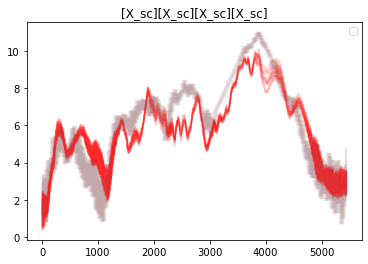

In [136]:
a3_predict_dc = runmodel(model_dcnn,Xa3,Ya3_ori)
showresult(a3_predict_dc,Ya3_ori)

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 4s 347us/sample - loss: 0.1213 - val_loss: 0.0206
Epoch 2/30
11665/11665 [==============================] - 4s 316us/sample - loss: 0.0542 - val_loss: 0.0177
Epoch 3/30
11665/11665 [==============================] - 5s 394us/sample - loss: 0.0447 - val_loss: 0.0166
Epoch 4/30
11665/11665 [==============================] - 4s 332us/sample - loss: 0.0395 - val_loss: 0.0158
Epoch 5/30
11665/11665 [==============================] - 4s 354us/sample - loss: 0.0364 - val_loss: 0.0155
Epoch 6/30
11665/11665 [==============================] - 4s 360us/sample - loss: 0.0340 - val_loss: 0.0154
Epoch 7/30
11665/11665 [==============================] - 4s 348us/sample - loss: 0.0323 - val_loss: 0.0150
Epoch 8/30
11665/11665 [==============================] - 4s 355us/sample - loss: 0.0311 - val_loss: 0.0151
Epoch 9/30
11665/11665 [==============================] - 4s 348us/sample - loss: 0.030

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


MSE         0.020146
rmse        0.141937
R2          0.924443
NSE         0.924421
mape    36471.785156
mae         0.108651
mpe     19987.001953
dtype: float64
MSE     0.014702
rmse    0.121251
R2      0.772130
NSE     0.772321
mape         inf
mae     0.088940
mpe          NaN
dtype: float64


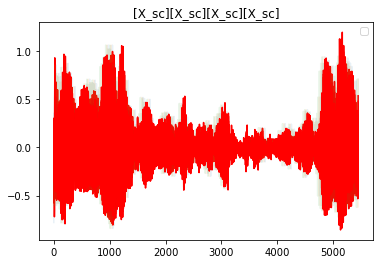

In [125]:
d3_predict_dc = runmodel(model_dcnn,Xd3,Yd3_ori)
showresult(d3_predict_dc,Yd3_ori)

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 4s 343us/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 2/30
11665/11665 [==============================] - 4s 345us/sample - loss: 0.0087 - val_loss: 0.0036
Epoch 3/30
11665/11665 [==============================] - 4s 345us/sample - loss: 0.0083 - val_loss: 0.0035
Epoch 4/30
11665/11665 [==============================] - 4s 366us/sample - loss: 0.0079 - val_loss: 0.0034
Epoch 5/30
11665/11665 [==============================] - 5s 406us/sample - loss: 0.0075 - val_loss: 0.0033
Epoch 6/30
11665/11665 [==============================] - 4s 357us/sample - loss: 0.0072 - val_loss: 0.0033
Epoch 7/30
11665/11665 [==============================] - 4s 352us/sample - loss: 0.0069 - val_loss: 0.0032
Epoch 8/30
11665/11665 [==============================] - 4s 343us/sample - loss: 0.0067 - val_loss: 0.0031
Epoch 9/30
11665/11665 [==============================] - 4s 326us/sample - loss: 0.006

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-c

MSE     0.004925
rmse    0.070179
R2      0.680510
NSE     0.680492
mape         inf
mae     0.053218
mpe          NaN
dtype: float64
MSE     0.002863
rmse    0.053509
R2      0.410787
NSE     0.410919
mape         inf
mae     0.037220
mpe          NaN
dtype: float64


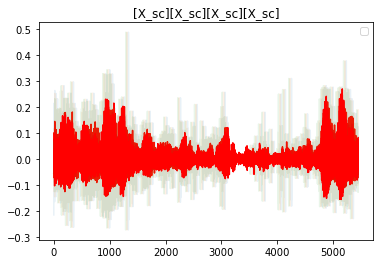

In [126]:
d2_predict_dc = runmodel(model_dcnn,Xd2,Yd2_ori)
showresult(d2_predict_dc,Yd2_ori)

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 3s 293us/sample - loss: 0.0019 - val_loss: 0.0014
Epoch 2/30
11665/11665 [==============================] - 4s 321us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 3/30
11665/11665 [==============================] - 4s 324us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 4/30
11665/11665 [==============================] - 4s 361us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 5/30
11665/11665 [==============================] - 4s 313us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 6/30
11665/11665 [==============================] - 4s 341us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 7/30
11665/11665 [==============================] - 4s 355us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 8/30
11665/11665 [==============================] - 4s 333us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 9/30
11665/11665 [==============================] - 4s 342us/sample - loss: 0.001

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


MSE        0.001661
rmse       0.040760
R2         0.087942
NSE        0.087956
mape    3028.464355
mae        0.025015
mpe       78.501663
dtype: float64
MSE     0.001354
rmse    0.036798
R2      0.013679
NSE     0.013683
mape         inf
mae     0.017443
mpe          NaN
dtype: float64


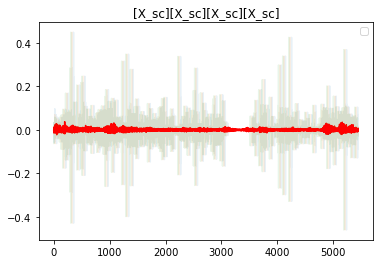

In [127]:
d1_predict_dc = runmodel(model_dcnn,Xd1,Yd1_ori)
showresult(d1_predict_dc,Yd1_ori)

In [118]:
verbose, epochs,batch = 1, 30,16
lstm = build_lstm()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 200)               169600    
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 72)                7272      
Total params: 196,972
Trainable params: 196,972
Non-trainable params: 0
_____________________________________________________

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 6s 554us/sample - loss: 1.2844 - val_loss: 0.9063
Epoch 2/30
11665/11665 [==============================] - 6s 543us/sample - loss: 0.7671 - val_loss: 0.9740
Epoch 3/30
11665/11665 [==============================] - 6s 541us/sample - loss: 0.7521 - val_loss: 0.8057
Epoch 4/30
11665/11665 [==============================] - 6s 536us/sample - loss: 0.7376 - val_loss: 0.8246
Epoch 5/30
11665/11665 [==============================] - 6s 550us/sample - loss: 0.7305 - val_loss: 0.6401
Epoch 6/30
11665/11665 [==============================] - 6s 555us/sample - loss: 0.7292 - val_loss: 0.6206
Epoch 7/30
11665/11665 [==============================] - 6s 555us/sample - loss: 0.7256 - val_loss: 0.6746
Epoch 8/30
11665/11665 [==============================] - 7s 558us/sample - loss: 0.7167 - val_loss: 0.7610
Epoch 00008: early stopping


MSE     0.559358
rmse    0.747902
R2      0.843416
NSE     0.843418
mape    0.984215
mae     0.606528
mpe     0.070815
dtype: float64
MSE     0.760987
rmse    0.872345
R2      0.864401
NSE     0.864424
mape    0.149473
mae     0.736550
mpe    -0.035223
dtype: float64


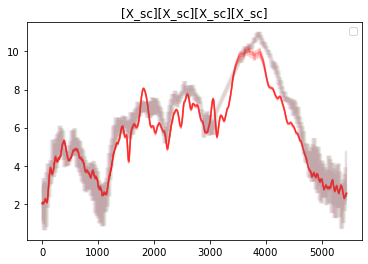

In [137]:
a3_predict_lstm = runmodel(lstm,Xa3,Ya3_ori)
showresult(a3_predict_lstm,Ya3_ori)

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 6s 546us/sample - loss: 0.5529 - val_loss: 0.0716
Epoch 2/30
11665/11665 [==============================] - 6s 540us/sample - loss: 0.2544 - val_loss: 0.0644
Epoch 3/30
11665/11665 [==============================] - 6s 540us/sample - loss: 0.2436 - val_loss: 0.0606
Epoch 4/30
11665/11665 [==============================] - 7s 577us/sample - loss: 0.2314 - val_loss: 0.0565
Epoch 5/30
11665/11665 [==============================] - 7s 582us/sample - loss: 0.2142 - val_loss: 0.0508
Epoch 6/30
11665/11665 [==============================] - 7s 575us/sample - loss: 0.1886 - val_loss: 0.0435
Epoch 7/30
11665/11665 [==============================] - 7s 561us/sample - loss: 0.1602 - val_loss: 0.0414
Epoch 8/30
11665/11665 [==============================] - 7s 559us/sample - loss: 0.1444 - val_loss: 0.0409
Epoch 9/30
11665/11665 [==============================] - 7s 577us/sample - loss: 0.136

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


MSE         0.083466
rmse        0.288904
R2          0.686927
NSE         0.686872
mape    37222.953125
mae         0.234363
mpe    -21560.943359
dtype: float64
MSE     0.032135
rmse    0.179263
R2      0.502142
NSE     0.502335
mape         inf
mae     0.136948
mpe         -inf
dtype: float64


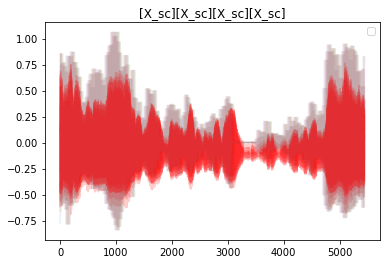

In [138]:
d3_predict_lstm = runmodel(lstm,Xd3,Yd3_ori)
showresult(d3_predict_lstm,Yd3_ori)

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 7s 565us/sample - loss: 0.0138 - val_loss: 0.0039
Epoch 2/30
11665/11665 [==============================] - 7s 623us/sample - loss: 0.0110 - val_loss: 0.0037
Epoch 3/30
11665/11665 [==============================] - 6s 551us/sample - loss: 0.0107 - val_loss: 0.0037
Epoch 4/30
11665/11665 [==============================] - 6s 556us/sample - loss: 0.0105 - val_loss: 0.0037
Epoch 5/30
11665/11665 [==============================] - 6s 550us/sample - loss: 0.0103 - val_loss: 0.0037
Epoch 6/30
11665/11665 [==============================] - 7s 560us/sample - loss: 0.0102 - val_loss: 0.0036
Epoch 7/30
11665/11665 [==============================] - 7s 562us/sample - loss: 0.0101 - val_loss: 0.0036
Epoch 8/30
11665/11665 [==============================] - 7s 574us/sample - loss: 0.0099 - val_loss: 0.0036
Epoch 9/30
11665/11665 [==============================] - 7s 570us/sample - loss: 0.009

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-c

MSE     0.008229
rmse    0.090714
R2      0.466176
NSE     0.466154
mape         inf
mae     0.069763
mpe          NaN
dtype: float64
MSE     0.003560
rmse    0.059667
R2      0.267485
NSE     0.267516
mape         inf
mae     0.041196
mpe          NaN
dtype: float64


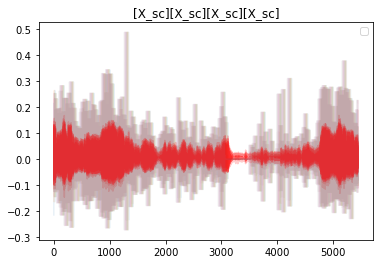

In [139]:
d2_predict_lstm = runmodel(lstm,Xd2,Yd2_ori)
showresult(d2_predict_lstm,Yd2_ori)

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 6s 525us/sample - loss: 0.0022 - val_loss: 0.0014
Epoch 2/30
11665/11665 [==============================] - 6s 554us/sample - loss: 0.0021 - val_loss: 0.0014
Epoch 3/30
11665/11665 [==============================] - 7s 574us/sample - loss: 0.0020 - val_loss: 0.0014
Epoch 4/30
11665/11665 [==============================] - 6s 537us/sample - loss: 0.0020 - val_loss: 0.0014
Epoch 5/30
11665/11665 [==============================] - 7s 573us/sample - loss: 0.0020 - val_loss: 0.0014
Epoch 6/30
11665/11665 [==============================] - 7s 583us/sample - loss: 0.0020 - val_loss: 0.0014
Epoch 7/30
11665/11665 [==============================] - 6s 536us/sample - loss: 0.0019 - val_loss: 0.0014
Epoch 8/30
11665/11665 [==============================] - 7s 584us/sample - loss: 0.0019 - val_loss: 0.0014
Epoch 9/30
11665/11665 [==============================] - 7s 576us/sample - loss: 0.001

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


MSE        0.001807
rmse       0.042509
R2         0.007999
NSE        0.007997
mape    2742.635498
mae        0.026585
mpe     -769.324219
dtype: float64
MSE     0.001379
rmse    0.037136
R2     -0.004563
NSE    -0.004564
mape         inf
mae     0.017879
mpe          NaN
dtype: float64


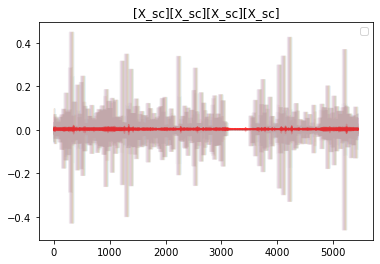

In [140]:
d1_predict_lstm = runmodel(lstm,Xd1,Yd1_ori)
showresult(d1_predict_lstm,Yd1_ori)

In [155]:
def build_mod_lstm_batch():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    #x = layers.CuDNNLSTM(100,input_shape=(n_past, n_features),return_sequences=False)(x)
    x = layers.BatchNormalization()(x)#add
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='tanh')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(n_future,activation='tanh')(x)
    
    #out = layers.Reshape((1,n_future))(x)
    model = keras.Model(inputs=[input], outputs=out)

    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model

mod_lstm=build_mod_lstm_batch()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 200)               169600    
_________________________________________________________________
batch_normalization_8 (Batch (None, 200)               800       
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 72)                727

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 8s 647us/sample - loss: 11.2777 - val_loss: 38.6859
Epoch 2/30
11665/11665 [==============================] - 7s 594us/sample - loss: 10.2298 - val_loss: 35.1479
Epoch 3/30
11665/11665 [==============================] - 7s 597us/sample - loss: 9.0716 - val_loss: 33.8911
Epoch 4/30
11665/11665 [==============================] - 7s 599us/sample - loss: 8.5976 - val_loss: 33.2888
Epoch 5/30
11665/11665 [==============================] - 7s 602us/sample - loss: 8.3774 - val_loss: 33.0572
Epoch 6/30
11665/11665 [==============================] - 7s 602us/sample - loss: 8.3557 - val_loss: 32.8351
Epoch 7/30
11665/11665 [==============================] - 7s 592us/sample - loss: 8.3001 - val_loss: 32.7448
Epoch 8/30
11665/11665 [==============================] - 7s 597us/sample - loss: 8.1948 - val_loss: 32.6776
Epoch 9/30
11665/11665 [==============================] - 7s 588us/sample - l

MSE     7.633266
rmse    2.762837
R2     -1.136796
NSE    -1.136796
mape    1.065357
mae     2.086679
mpe    -0.726950
dtype: float64
MSE     32.542995
rmse     5.704647
R2      -4.797963
NSE     -4.797817
mape     0.799388
mae      5.190712
mpe     -0.797696
dtype: float64


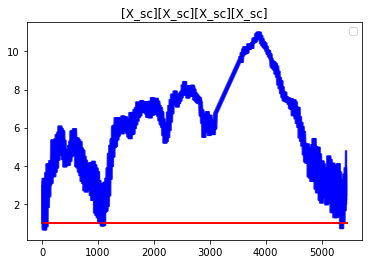

In [156]:
a3_predict_modLSTM = runmodel(mod_lstm,Xa3,Ya3_ori)
showresult(a3_predict_modLSTM,Ya3_ori)

In [ ]:
d3_predict_modLSTM = runmodel(mod_lstm,Xd3,Yd3_ori)
showresult(d3_predict_modLSTM,Yd3_ori)

# Inverse transform

In [129]:
# inverse transform
def inverse_WT(coeffs):
#predTrain = inverse_WT(cA3ytrain,d1_PreTrain,d1_PreTrain,d1_PreTrain)
#predTest = inverse_WT(cA3ytest,cD3ytest,cD2ytest,cD1ytest)
    wav=list()
    for i in range(coeffs[0].shape[0]):
        iwave = pywt.iswt([coeff[i,:] for coeff in coeffs],'db4')
        wav.append(iwave)
    return np.array(wav)


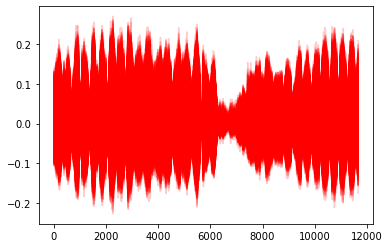

In [142]:
plt.plot(d2_predict_lstm[0],color='red',alpha=.2)

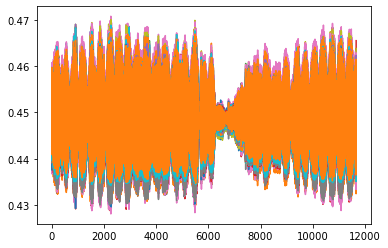

In [135]:
scaler = StandardScaler().fit(Yd2[0])
sig = scaler.inverse_transform(d2_predict_lstm[0])
plt.plot(sig)

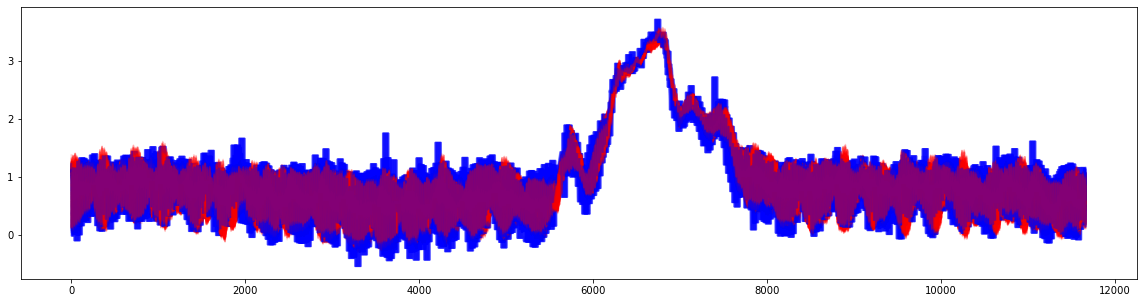

In [147]:
# a3_predict_lstm,d3_predict_dc , d2_predict_dc,d1_predict_dc
iwave = inverse_WT([a3_predict_dc[0],d3_predict_dc[0],d2_predict_dc[0],d1_predict_dc[0]])
#check = inverse_WT(Ya3[0],Yd3[0],Yd2[0],Yd1[0])

ytrain = masterY[0]
#scaler_tar = MinMaxScaler()
#scaler_tar.fit(iwave)
#train = scaler_tar.fit_transform(ytrain)
#iwave = scaler_tar.inverse_transform(iwave)
#ytest = ytest.reshape(Y[1].shape)
plt.figure(figsize=(20,5))
for i in range(72):
    plt.plot(ytrain[:,i],color='blue',alpha=0.1)
    plt.plot(iwave[:,i],alpha=0.1,color='red')

In [111]:
print(np.max(iwave),np.min(iwave))
print(np.max(iwave),np.min(iwave))

0.4615154 -0.2505561
0.4615154 -0.2505561


LSTM batch

In [78]:
def build_mod_lstm_batch():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=True)(input)
    x = layers.CuDNNLSTM(100,input_shape=(n_past, n_features),return_sequences=False)(x)
    x = layers.BatchNormalization()(x)#add
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='tanh')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(n_future,activation='tanh')(x)
    
    #out = layers.Reshape((1,n_future))(x)
    model = keras.Model(inputs=[input], outputs=out)

    model.compile(loss='mse', optimizer=my_optimizer,metrics='accuracy')
    model.summary()
    return model

In [83]:
verbose, epochs,batch = 1, 30,8
#my_optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
my_optimizer = 'adam'
loss_f = 'mean_squared_logarithmic_error' #notwork
callbacks = [reduce_lr]
# callbacks = [callback_early_stopping,reduce_lr]
mod_lstm = build_mod_lstm_batch()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 168, 200)          169600    
_________________________________________________________________
cu_dnnlstm_15 (CuDNNLSTM)    (None, 100)               120800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dropout_46 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_47 (Dropout)         (None, 100)               0  

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 46s 4ms/sample - loss: 0.2066 - val_loss: 0.0604
Epoch 2/30
11665/11665 [==============================] - 44s 4ms/sample - loss: 0.0339 - val_loss: 0.0053
Epoch 3/30
11665/11665 [==============================] - 44s 4ms/sample - loss: 0.0072 - val_loss: 0.0045
Epoch 4/30
11665/11665 [==============================] - 44s 4ms/sample - loss: 0.0059 - val_loss: 0.0032
Epoch 5/30
11665/11665 [==============================] - 45s 4ms/sample - loss: 0.0055 - val_loss: 0.0070
Epoch 6/30
11665/11665 [==============================] - 44s 4ms/sample - loss: 0.0053 - val_loss: 0.0063
Epoch 7/30
11665/11665 [==============================] - 45s 4ms/sample - loss: 0.0051 - val_loss: 0.0080
Epoch 8/30
11665/11665 [==============================] - 44s 4ms/sample - loss: 0.0050 - val_loss: 0.0176
Epoch 9/30
11665/11665 [==============================] - 45s 4ms/sample - loss: 0.0048 - val_l

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


MSE     0.002140
rmse    0.046263
R2     -0.040059
NSE    -0.040045
mape         inf
mae     0.029376
mpe          inf
dtype: float64
MSE     0.001645
rmse    0.040555
R2     -0.060495
NSE    -0.060489
mape    0.046244
mae     0.021711
mpe    -0.008084
dtype: float64


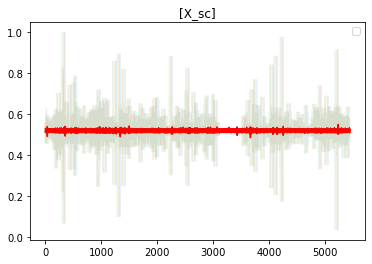

In [84]:
d1_PreTrain_c,d1_PreTest_c = runmodel(mod_lstm,Xd1,Yd1)
showresult([d1_PreTrain_c,d1_PreTest_c],Yd1)

In [63]:
def build_mod():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(100,input_shape=(n_past, n_features),return_sequences=True)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100)(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(n_future,activation='sigmoid')(x)
    
    #out = layers.Reshape((1,n_future))(x)
    model = keras.Model(inputs=[input], outputs=out)

    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model

In [64]:
verbose, epochs,batch = 1, 30,8
#my_optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
my_optimizer = 'adam'
loss_f = 'mse'

mod = build_mod()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 168, 100)          44800     
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 200)               241600    
_________________________________________________________________
dropout_34 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_35 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 72)                727

In [65]:
d1_Predict_mod = runmodel(mod,Xd1,[yD1_train,yD1_test])
showresult(d1_Predict_mod,[yD1_train,yD1_test])

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0615 - val_loss: 0.0018
Epoch 2/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0047 - val_loss: 0.0014
Epoch 3/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0027 - val_loss: 0.0014
Epoch 4/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0022 - val_loss: 0.0014
Epoch 5/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0020 - val_loss: 0.0014
Epoch 6/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0019 - val_loss: 0.0014
Epoch 7/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0019 - val_loss: 0.0014
Epoch 8/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0019 - val_loss: 0.0014
Epoch 9/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0019 - val_l

KeyboardInterrupt: 

GRU no work

ann no work


# Just throw all to dl

In [32]:
def build_lstm4():
    global n_past,n_future,n_features
    inputA3 = keras.Input(shape=(n_past, n_features), name="cA3")
    inputD3 = keras.Input(shape=(n_past, n_features), name="cD3")
    inputD2 = keras.Input(shape=(n_past, n_features), name="cD2")
    inputD1 = keras.Input(shape=(n_past, n_features), name="cD1")
    #x is the CNN for approximate
    a = layers.CuDNNLSTM(200,return_sequences=False)(inputA3)
    a = layers.Dropout(0.2)(a)
    a = layers.Dense(100,activation = 'relu')(a)
    a = layers.Dropout(0.2)(a)
    a = layers.Dense(100, activation='relu')(a)

    #y is the LSTM for detail  
    b = layers.CuDNNLSTM(200,return_sequences=False)(inputD3)
    b = layers.Dropout(0.2)(b)
    b = layers.Dense(100,activation = 'relu')(b)
    b = layers.Dropout(0.2)(b)
    b = layers.Dense(10,activation='sigmoid')(b)
    
    c = layers.CuDNNLSTM(200,return_sequences=False)(inputD2)
    c = layers.Dropout(0.2)(c)
    c= layers.Dense(100,activation = 'relu')(c)
    c = layers.Dropout(0.2)(c)
    c = layers.Dense(10,activation='sigmoid')(c)
    
    d = layers.CuDNNLSTM(200,return_sequences=False)(inputD1)
    d = layers.Dropout(0.2)(d)
    d = layers.Dense(100,activation = 'relu')(d)
    d = layers.Dropout(0.2)(d)
    d = layers.Dense(10,activation='sigmoid')(d)
    #combining 2 lstm
    com = layers.concatenate([a,b,c,d])
    # z = LSTM(200, activation='relu', return_sequences=False)(com)
    # z = Dense(100, activation="relu")
    z = layers.Dense(n_future)(com)
    model = keras.Model(inputs=[inputA3, inputD3,inputD2,inputD1], outputs=z)
    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model

In [33]:
X,Y = autosplit(data_mar)

In [34]:
Xtrain = (Xa3[0],Xd3[0],Xd2[0],Xd1[0])
Xtest = (Xa3[1],Xd3[1],Xd2[1],Xd1[1])
model=build_lstm4()
history = model.fit(Xtrain,Y[0],epochs=epochs,validation_data=(Xtest,Y[1]),batch_size=batch,verbose=verbose,callbacks=callbacks)
trainPred = model.predict(Xtrain)
testPred = model.predict(Xtest)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cA3 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD3 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD2 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD1 (InputLayer)                [(None, 168, 10)]    0                                            
____________________________________________________________________________________________

NameError: name 'model' is not defined

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cA3 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD3 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD2 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD1 (InputLayer)                [(None, 168, 10)]    0                                            
___________________________________________________________________________________________

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


MSE     1.531426
rmse    1.237508
R2     -2.160452
NSE    -2.160470
mape         inf
mae     1.011583
mpe          NaN
dtype: float64
MSE     5.483742
rmse    2.341739
R2     -6.729433
NSE    -6.731115
mape    0.992382
mae     2.172115
mpe    -0.989971
dtype: float64


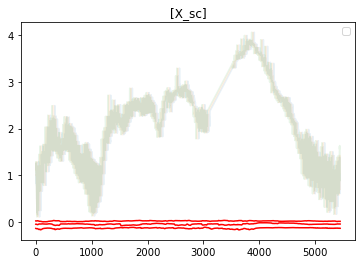

In [36]:
trainPred = build_lstm4().predict(Xtrain)
testPred = build_lstm4().predict(Xtest)

showresult([trainPred,testPred],Y)

In [55]:
def ab_lstm():
    global n_past,n_future,n_features
    inputA3 = keras.Input(shape=(n_past, n_features), name="cA3")
    inputD3 = keras.Input(shape=(n_past, n_features), name="cD3")
    inputD2 = keras.Input(shape=(n_past, n_features), name="cD2")
    inputD1 = keras.Input(shape=(n_past, n_features), name="cD1")
    #x is the CNN for approximate
    a = layers.CuDNNLSTM(200,return_sequences=False)(inputA3)
    a = layers.Dropout(0.2)(a)
    a = layers.Dense(100,activation = 'relu')(a)
    a = layers.Dropout(0.2)(a)
    a = layers.Dense(100, activation='relu')(a)

    #y is the LSTM for detail  
    b = layers.LSTM(200,activation = 'sigmoid',return_sequences=False)(inputD3)
    b = layers.Dense(50,activation='sigmoid')(b)
    
    c = layers.LSTM(200,activation = 'sigmoid',return_sequences=False)(inputD2)
    c = layers.Dense(50,activation='sigmoid')(c)
    
    d = layers.LSTM(200,activation = 'sigmoid',return_sequences=False)(inputD1)
    d = layers.Dense(10,activation='sigmoid')(d)
    #combining 2 lstm
    com = layers.concatenate([a,b,c,d])
    # z = LSTM(200, activation='relu', return_sequences=False)(com)
    z = layers.Dense(100, activation="sigmoid")(com)
    # z = layers.CuDNNLSTM(200,return_sequences=False)(z)
    z = layers.Dense(n_future)(z)
    model = keras.Model(inputs=[inputA3, inputD3,inputD2,inputD1], outputs=z)
    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model

In [56]:
Xtrain = (Xa3[0],Xd3[0],Xd2[0],Xd1[0])
Xtest = (Xa3[1],Xd3[1],Xd2[1],Xd1[1])
model=ab_lstm()

history = model.fit(Xtrain,Y[0],epochs=epochs,validation_data=(Xtest,Y[1]),batch_size=batch,verbose=verbose,callbacks=callbacks)
trainPred = model.predict(Xtrain)
testPred = model.predict(Xtest)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cA3 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cu_dnnlstm_57 (CuDNNLSTM)       (None, 200)          169600      cA3[0][0]                        
__________________________________________________________________________________________________
dropout_60 (Dropout)            (None, 200)          0           cu_dnnlstm_57[0][0]              
__________________________________________________________________________________________________
dense_108 (Dense)               (None, 100)          20100       dropout_60[0][0]                 
___________________________________________________________________________________________

KeyboardInterrupt: 

In [ ]:
showresult([trainPred,testPred],Y)